In [1]:
!git clone https://github.com/3254c/DeepKINET.git

Cloning into 'DeepKINET'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 442 (delta 78), reused 97 (delta 31), pack-reused 282
Receiving objects: 100% (442/442), 7.83 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (210/210), done.


#Installation

In [2]:
!pip install einops==0.7.0 scanpy==1.9.6 umap==0.1.1 anndata==0.10.3 scvelo==0.2.5 leidenalg==0.10.1 numpy==1.23.5 pandas==1.5.3

#Import packages

In [3]:
import torch
import numpy as np
from statistics import mean
import torch.distributions as dist
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn import init
import functorch
from einops import rearrange, reduce, repeat
import scanpy as sc
import leidenalg
import umap
import anndata as ad
import scvelo as scv
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('/content/DeepKINET/src/deepkinet')
import workflow
import utils
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

#Load data and preprocessing
DeepKINET requires unspliced and spliced mRNA count data. After pre-processing, normalized counts are converted back to raw counts.

In [4]:
adata = scv.datasets.pancreas()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
raw_adata = scv.datasets.pancreas()
adata.layers['spliced'] = raw_adata[:, adata.var_names].layers['spliced']
adata.layers['unspliced'] = raw_adata[:, adata.var_names].layers['unspliced']

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


#Estimation of dynamics and kinetics
DeepKINET first performs dynamics estimation and then kinetics estimation based on that.

In [6]:
adata, deepkinet_exp = workflow.estimate_kinetics(adata)

make_sample_one_hot_mat
batch_key is None
loss_mode poisson
Start Dynamics opt
Dynamics opt patience 10
val loss mean (post 10 epochs) at epoch 0 is 7.378086090087891
val loss mean (post 10 epochs) at epoch 100 is 5.576953363418579
Early Stopping! at 102 epoch
Done Dynamics opt
Dynamics_last_val_loss:5.572981834411621
Dynamics_last_test_loss:11.451676368713379
Start Kinetics opt
Kinetics opt patience 10
val loss mean (post 10 epochs) at epoch 0 is 5.595578193664551
Early Stopping! at 25 epoch
Done Kinetics opt
Kinetics_last_val_loss:5.571744441986084
Kinetics_last_test_loss:11.444265365600586
train_s_correlation 0.37704850873834056
train_u_correlation 0.2845727390735303
val_s_correlation 0.33570517298738606
val_u_correlation 0.19822968724783932
test_s_correlation 0.33990284355111994
test_u_correlation 0.19832292480585553


#Visualization of dynamics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing velocity graph (using 1/12 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'latent_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'latent_velocity_original_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_.latent_velocity.png


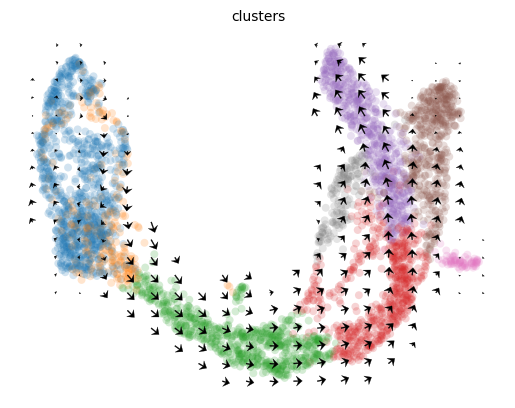

In [7]:
color = 'clusters'
embeddings = 'X_umap'
utils.embedding_func(adata, color, embeddings = embeddings)

#Visualization kinetic rates

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


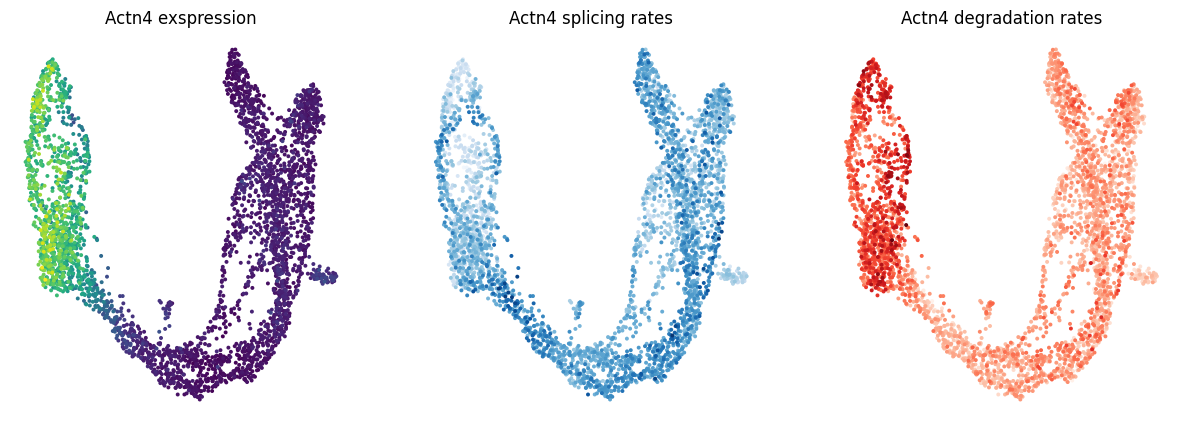

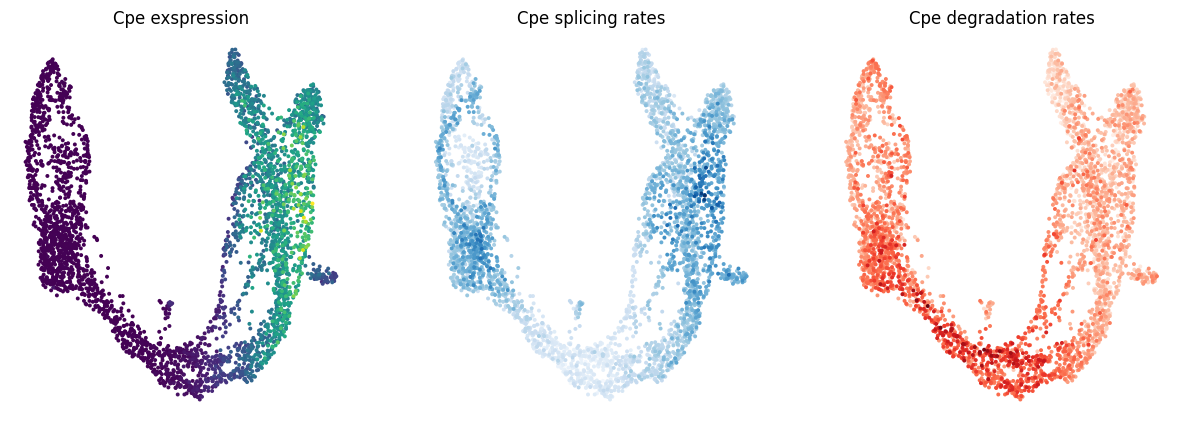

In [8]:
gene_a = 'Actn4'
utils.visualization_kinetics(adata, gene_a, save_path = 'test_a.jpg')
gene_b = 'Cpe'
utils.visualization_kinetics(adata, gene_b, save_path = 'test_b.jpg')

#Clustering by kinetic rates
After z-transforming the kinetics rates, perform leiden clustering on the genes. Clustering is performed using splicing rate and degdradation rate separately, or both.

In [9]:
utils.kinetic_rate_cluster_separate(adata)
utils.kinetic_rate_cluster_both(adata)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


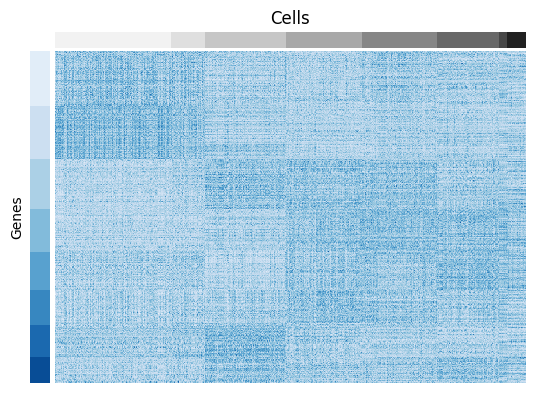

In [10]:
from matplotlib.gridspec import GridSpec

cluster_mapping = {
    'Ductal': '0',
    'Ngn3 low EP': '1',
    'Ngn3 high EP': '2',
    'Pre-endocrine': '3',
    'Beta': '4',
    'Alpha': '5',
    'Delta': '6',
    'Epsilon': '7'
}

adata.obs['clusters_int'] = adata.obs['clusters'].map(cluster_mapping)

cell_sort_index = 'clusters_int'
gene_sort_index = 'splicing_rate_leiden'

gs = GridSpec(20, 20)
ss_top = gs.new_subplotspec((0, 1), rowspan=1, colspan=19)
ss_left = gs.new_subplotspec((1, 0), rowspan=18, colspan=1)
ss_center = gs.new_subplotspec((1, 1), rowspan=18, colspan=19)

ax_top = plt.subplot(ss_top)
ax_left = plt.subplot(ss_left)
ax_center = plt.subplot(ss_center)

sorted_splicing_rates = pd.DataFrame(adata[list(adata.obs.sort_values(cell_sort_index).index), list(adata.var.sort_values(gene_sort_index).index)].layers['splicing_rate_z'],
                                     index = list(adata.obs.sort_values(cell_sort_index)[cell_sort_index]),
                                     columns = list(adata.var.sort_values(gene_sort_index)[gene_sort_index]))
sns.heatmap(sorted_splicing_rates.T, xticklabels = False, yticklabels = False, cmap = 'Blues', cbar = False, ax = ax_center)
sns.heatmap(np.array(adata.var.sort_values(gene_sort_index)[gene_sort_index].astype(float))[:, np.newaxis], xticklabels = False, yticklabels = False, cbar=False, ax=ax_left, cmap= sns.color_palette("Blues", len(list(set(list(adata.var.sort_values(gene_sort_index)[gene_sort_index]))))))
sns.heatmap(np.array(adata.obs.sort_values(cell_sort_index)[cell_sort_index].astype(float))[np.newaxis, :], xticklabels = False, yticklabels = False, cbar=False, ax=ax_top, cmap= sns.color_palette("Greys", len(list(set(list(adata.obs.sort_values(cell_sort_index)[cell_sort_index]))))))

ax_top.set_title("Cells")
ax_left.set_ylabel("Genes")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


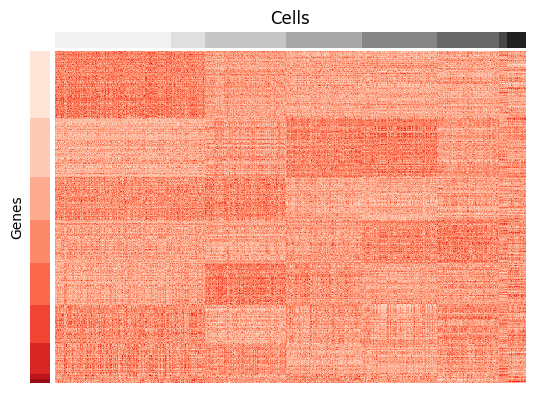

In [11]:
cell_sort_index = 'clusters_int'
gene_sort_index = 'degradation_rate_leiden'

gs = GridSpec(20, 20)
ss_top = gs.new_subplotspec((0, 1), rowspan=1, colspan=19)
ss_left = gs.new_subplotspec((1, 0), rowspan=18, colspan=1)
ss_center = gs.new_subplotspec((1, 1), rowspan=18, colspan=19)

ax_top = plt.subplot(ss_top)
ax_left = plt.subplot(ss_left)
ax_center = plt.subplot(ss_center)

sorted_splicing_rates = pd.DataFrame(adata[list(adata.obs.sort_values(cell_sort_index).index), list(adata.var.sort_values(gene_sort_index).index)].layers['degradation_rate_z'],
                                     index = list(adata.obs.sort_values(cell_sort_index)[cell_sort_index]),
                                     columns = list(adata.var.sort_values(gene_sort_index)[gene_sort_index]))
sns.heatmap(sorted_splicing_rates.T, xticklabels = False, yticklabels = False, cmap = 'Reds', cbar = False, ax = ax_center)

ax_top.set_title("Cells")

sns.heatmap(np.array(adata.var.sort_values(gene_sort_index)[gene_sort_index].astype(float))[:, np.newaxis], xticklabels = False, yticklabels = False, cbar=False, ax=ax_left, cmap= sns.color_palette("Reds", len(list(set(list(adata.var.sort_values(gene_sort_index)[gene_sort_index]))))))
sns.heatmap(np.array(adata.obs.sort_values(cell_sort_index)[cell_sort_index].astype(float))[np.newaxis, :], xticklabels = False, yticklabels = False, cbar=False, ax=ax_top, cmap= sns.color_palette("Greys", len(list(set(list(adata.obs.sort_values(cell_sort_index)[cell_sort_index]))))))

ax_left.set_ylabel("Genes")
plt.show()

#Finding genes with highly differential kinetics rates

Extract genes with large changes in kinetic rates among cell populations.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ranking genes by splicing rates
Ranking genes by degradation rates


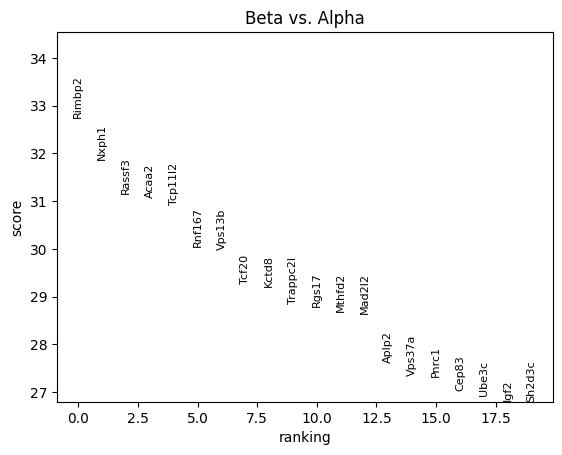

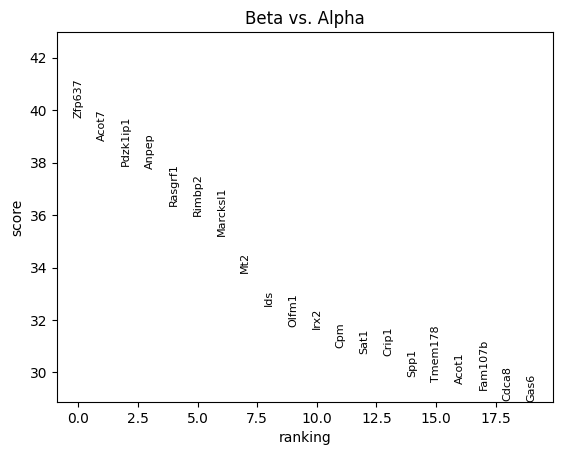

In [12]:
rank_genes_splicing = utils.rank_genes_groups_splicing(adata, groupby = 'clusters', groups = ['Beta'], reference = 'Alpha', method = 't-test', n_genes=20)
rank_genes_degradation = utils.rank_genes_groups_degradation(adata, groupby = 'clusters', groups = ['Beta'], reference = 'Alpha', method = 't-test', n_genes=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


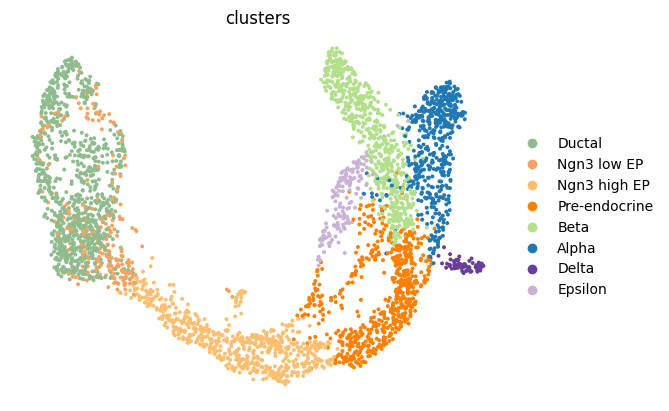

In [13]:
sc.pl.umap(adata, color = 'clusters', colorbar_loc = None, frameon = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


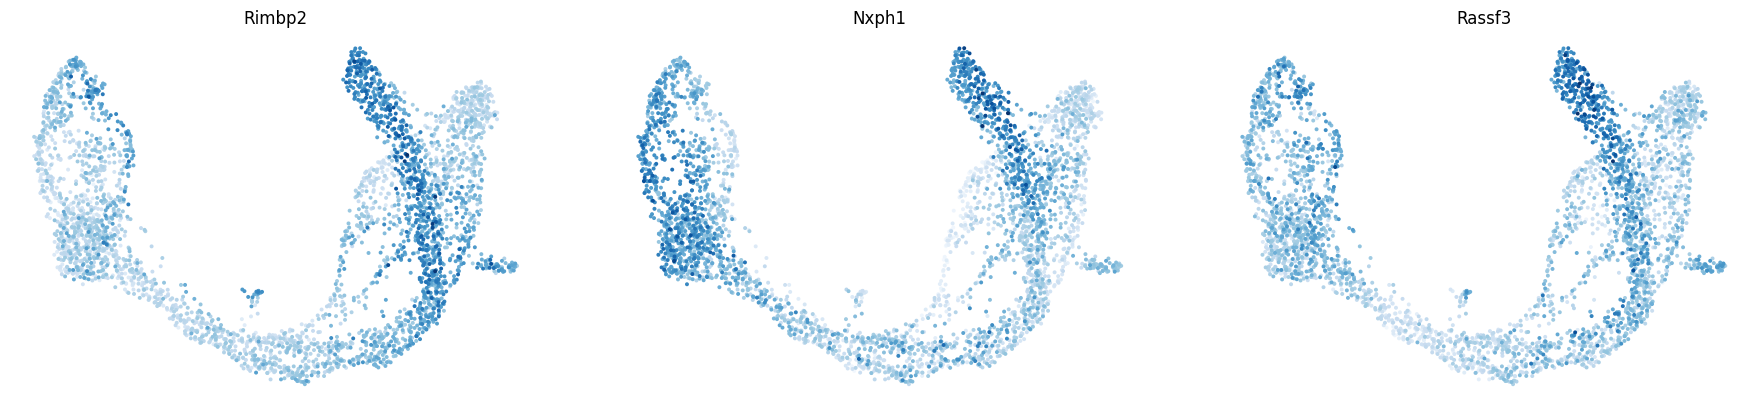

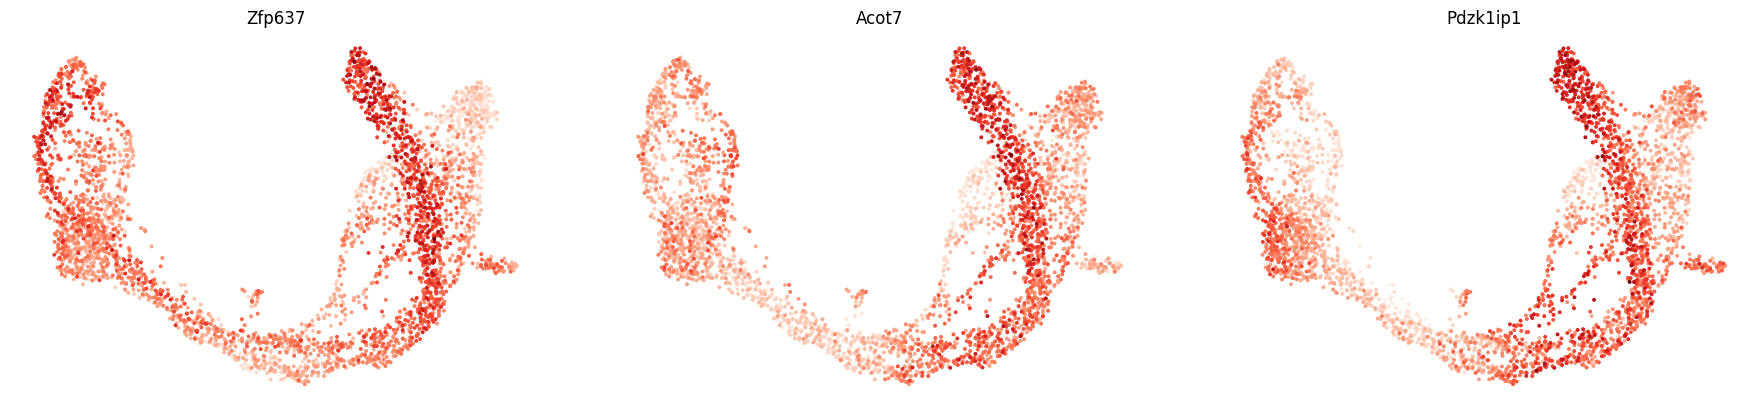

In [14]:
sc.pl.umap(adata, color = rank_genes_splicing[:3], layer = 'splicing_rate', colorbar_loc = None, frameon = False, color_map = 'Blues')
sc.pl.umap(adata, color = rank_genes_degradation[:3], layer = 'degradation_rate', colorbar_loc = None, frameon = False, color_map = 'Reds')